In [54]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [55]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
import math

In [56]:
current_date = datetime.now().strftime("%Y-%m-%d-%H-%M-%S")
file_directory = '/content/drive/MyDrive/momentum-strategies/technical_indicators'

In [57]:
qqq_df = pd.read_csv(f'{file_directory}/QQQ_daily161118_211117.csv')

In [58]:
tqqq_df = pd.read_csv(f'{file_directory}/TQQQ_daily161118_211117.csv')

In [59]:
def get_atr(closes, highs, lows, length):
  prev_closes = np.roll(closes, 1)
  prev_closes[0] = lows[0]
  true_ranges = np.maximum.reduce([abs(highs - prev_closes), abs(lows - highs), abs(lows - prev_closes)])
  return pd.Series(true_ranges).rolling(length).mean()

In [60]:
get_atr(qqq_df['Close'], qqq_df['High'], qqq_df['Low'], 20)

0            NaN
1            NaN
2            NaN
3            NaN
4            NaN
          ...   
1253    4.341995
1254    4.476495
1255    4.389494
1256    4.459494
1257    4.457992
Length: 1258, dtype: float64

In [61]:
def get_bollinger_bands(prices, length, width):
  # type(prices) == pandas.Series
  sma = prices.rolling(length).mean()
  stddev = prices.rolling(length).std(ddof=0)
  print(stddev)
  return sma, sma + width * stddev, sma - width * stddev

In [62]:
class Portfolio:
  def __init__(self, benchmark_df, benchmark_name):
    self.df = benchmark_df.copy()
    self.benchmark_closes = benchmark_df['Close'].to_numpy()
    self.benchmark_opens = benchmark_df['Open'].to_numpy()
    # self.benchmark_highs = benchmark_df['High'].to_numpy()
    # self.benchmark_lows = benchmark_df['Low'].to_numpy()
    self.benchmark_name = benchmark_name
  
  def init_config(self, initial_cash):
    self.initial_cash = initial_cash
    self.shares, self.cash, self.signals, self.buy_price = [np.zeros(len(self.benchmark_closes)) for _ in range(4)]

  def buy_and_hold(self, start, to_csv=False):
    self.name = self.benchmark_name + "_bnh"
    self.cash += self.initial_cash
    shares_delta = self.initial_cash // self.benchmark_opens[start]
    self.cash[start:] -= shares_delta * self.benchmark_opens[start]
    self.shares[start:] = shares_delta
    self.buy_price[start:] = self.benchmark_opens[start]
    self.save_to_df(to_csv)
    return self.df['portfolio_closes']

  def strategy(self, indicator, *parameters, to_csv=False):
    self.cash[0] = self.initial_cash
    getattr(self, 'get_' + indicator)(*parameters)
    getattr(self, indicator + '_signals')()
    self.name = "_".join([self.benchmark_name, indicator] + list(map(str, parameters)))
    for i in range(1, len(self.benchmark_closes)):
      self.cash[i] = self.cash[i - 1]
      self.shares[i] = self.shares[i - 1]
      self.signal_trading(i)
    self.save_to_df(to_csv)
    return self.df['portfolio_closes']

  def get_bollinger_bands(self, length, width):
    # type(prices) == pandas.Series
    self.sma = self.df['Close'].rolling(length).mean().to_numpy()
    stddev = self.df['Close'].rolling(length).std(ddof=0).to_numpy()
    self.bb_upper = self.sma + width * stddev 
    self.bb_lower = self.sma - width * stddev
  
  def bollinger_bands_signals(self):
    self.signals[(self.benchmark_closes > self.bb_upper)] = 1
    self.signals[(self.benchmark_closes < self.bb_lower)] = -1
  
  def signal_trading(self, i):
    # trade at day(i) open with previus day(i - 1) signals
    if self.signals[i - 1] > 0:
      shares_delta = self.cash[i] // self.benchmark_opens[i]
      self.shares[i] = self.shares[i - 1] + shares_delta
      self.cash[i] = self.cash[i - 1] - shares_delta * self.benchmark_opens[i]
      self.buy_price[i] = self.benchmark_opens[i]
    elif self.signals[i - 1] < 0:
      if self.shares[i] > 0:
        self.cash[i] = self.cash[i - 1] + self.shares[i] * self.benchmark_opens[i]
        self.shares[i] = 0
        self.buy_price[i] = 0
  
  def save_to_df(self, to_csv=False):
    for item in ['signals', 'sma', 'bb_upper', 'bb_lower', 'shares', 'cash']:
      try:
        self.df[item] = getattr(self, item)
      except AttributeError:
        pass
    self.df['portfolio_closes'] = self.cash + self.shares * self.benchmark_closes
    if to_csv:
      self.df.to_csv(f'{file_directory}/{current_date}_{self.name}.csv')

In [63]:
p = Portfolio(qqq_df, 'qqq')
p.init_config(10000)
p.buy_and_hold(20, to_csv=False)

0       10000.000000
1       10000.000000
2       10000.000000
3       10000.000000
4       10000.000000
            ...     
1253    32482.209585
1254    32823.340913
1255    32815.868672
1256    33049.100996
1257    33066.530332
Name: portfolio_closes, Length: 1258, dtype: float64

In [64]:
p.init_config(10000)
p.strategy('bollinger_bands', 20, 2, to_csv=False)

0       10000.000000
1       10000.000000
2       10000.000000
3       10000.000000
4       10000.000000
            ...     
1253    16775.650403
1254    16775.650403
1255    16775.650403
1256    16775.650403
1257    16775.650403
Name: portfolio_closes, Length: 1258, dtype: float64

In [65]:
def get_performance_df(benchmark_df, benchmark_name, initial_cash):
  performance_df = pd.DataFrame({'date': benchmark_df['Date']})
  portfolio = Portfolio(benchmark_df, benchmark_name)
  portfolio.init_config(initial_cash)
  performance_df[portfolio.name] = portfolio.buy_and_hold(20, to_csv=False)
  for length, width in [(20,2), (20,1)]:
    portfolio.init_config(initial_cash)
    performance_df[portfolio.name] = portfolio.strategy('bollinger_bands', length, width, to_csv=False)
  performance_df.to_csv(f'{file_directory}/{current_date}_performance.csv')
  return performance_df

In [66]:
def chart(performance_df, y_min, y_max, y_step):
  chart = performance_df.plot(x='date', grid=True, figsize=(40,25), xticks=np.arange(0, len(performance_df['date']), 20), yticks=np.arange(y_min, y_max, y_step), title="BB momentum strategy")
  chart.tick_params(axis='x', rotation=90)
  chart.figure.savefig(f'{file_directory}/{current_date}_performance.jpg')
  return chart

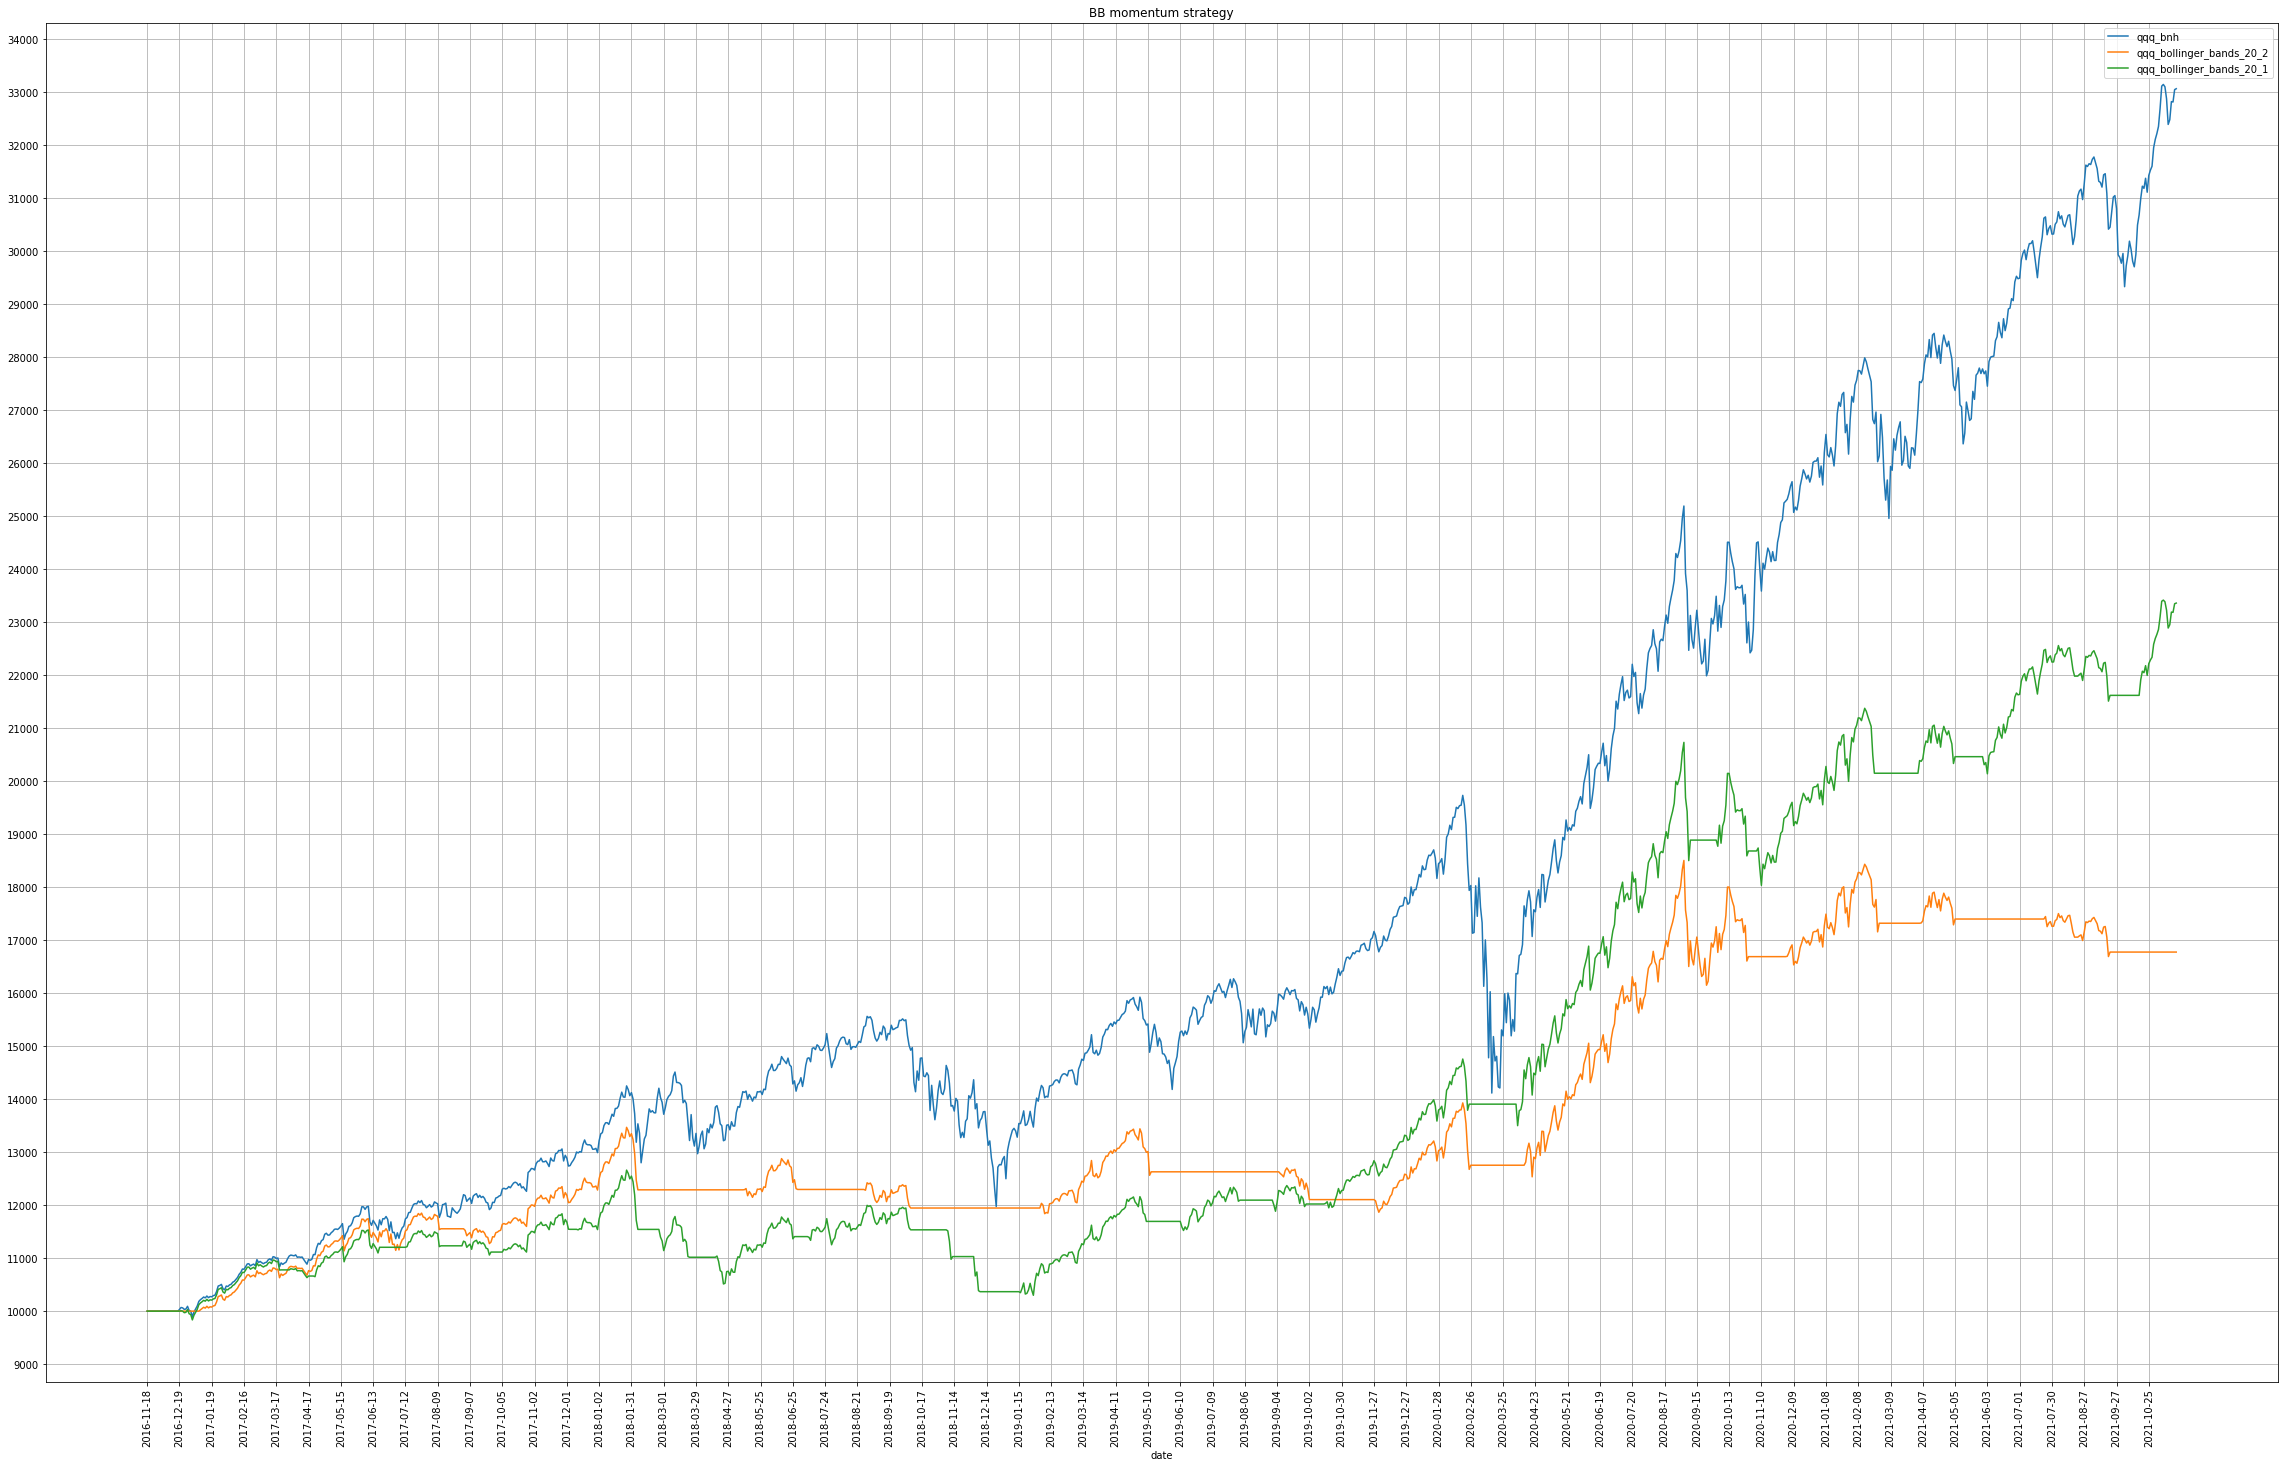

In [67]:
performance_df = get_performance_df(qqq_df, 'qqq', 10000)
chart(performance_df, 9000, 35000, 1000)